# Example 3.2 (univariate Gaussian, $\sigma^2$ fixed)

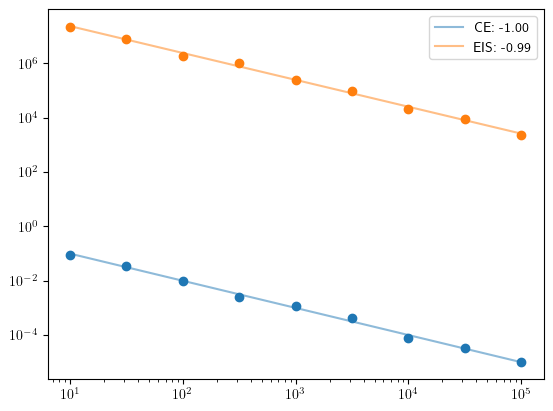

In [21]:
from jax.scipy.optimize import minimize
import jax.numpy as jnp
import jax.scipy as jsp
from tensorflow_probability.substrates.jax.distributions import TruncatedNormal, Normal
import jax.random as jrn
import matplotlib.pyplot as plt
from jax import vmap
from functools import partial

def ce_mu(samples, weights):
    mu = jnp.sum(samples * weights)/jnp.sum(weights)
    return mu

def eis_mu(samples, weights, logp, s2):
    N, = weights.shape
    X = jnp.array([jnp.ones(N), samples/jnp.sqrt(s2)]).reshape((2, N)).T

    wX = jnp.einsum('i,ij->ij', jnp.sqrt(weights), X)
    logh =  Normal(0, jnp.sqrt(s2)).log_prob(samples)
    y = jnp.sqrt(weights) * (logp - logh)
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    mu = beta[1] * jnp.sqrt(s2)
    return mu

def mu_ce_eis(N, key, s2, P):
    key, sk = jrn.split(key)

    samples = P.sample(N, sk)
    weights = jnp.ones(N)

    return jnp.array([
        ce_mu(samples, weights), 
        eis_mu(samples, weights, P.log_prob(samples), s2)
    ])


key = jrn.PRNGKey(10)
key ,*keys = jrn.split(key, 101)

keys = jnp.array(keys)

Ns = jnp.logspace(1, 5, 9).astype(int)

tau2 = 1.
s2 = 10000.

normal_estimators = partial(mu_ce_eis, P=Normal(0., jnp.sqrt(tau2)))

vars = jnp.array([
  (vmap(normal_estimators, (None, 0, None))(N, keys, s2)).var(axis=0)
  for N in Ns
])

coef_ce = jnp.polyfit(jnp.log(Ns), jnp.log(vars[:,0]), 1)
coef_eis = jnp.polyfit(jnp.log(Ns), jnp.log(vars[:,1]), 1)

plt.scatter(Ns, vars[:,0])
plt.scatter(Ns, vars[:,1])

plt.plot(Ns, jnp.exp(coef_ce[1]) * Ns ** coef_ce[0], label=f"CE: {coef_ce[0]:.2f}", alpha=.5)
plt.plot(Ns, jnp.exp(coef_eis[1]) * Ns ** coef_eis[0], label=f"EIS: {coef_eis[0]:.2f}", alpha=.5)

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

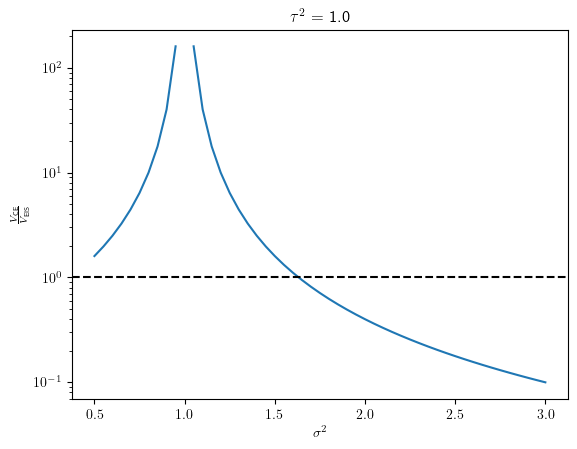

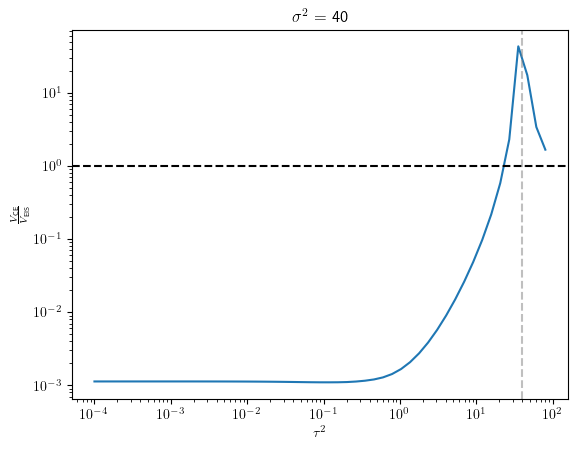

In [48]:
from tensorflow_probability.substrates.jax.distributions import MixtureSameFamily, Normal, Categorical
import tikzplotlib 
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command
def normal_are(s2, tau2, N, key, N_var):

    key, *keys = jrn.split(key, N_var + 1)
    keys = jnp.array(keys)

    normal_estimators = partial(mu_ce_eis, P=Normal(0., jnp.sqrt(tau2)))
    
    var_ce, var_eis = (vmap(normal_estimators, (None, 0, None))(N, keys, s2)).var(axis=0)
    return var_ce/var_eis

def mixture_are(s2, tau2, N, key, N_var):
    key, *keys = jrn.split(key, N_var + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([.5, .5])),
        components_distribution=Normal(jnp.array([-1., 1.]), jnp.sqrt(tau2))
    )
    mixture_estimators = partial(mu_ce_eis, P=P)
    
    var_ce, var_eis = (vmap(mixture_estimators, (None, 0, None))(N, keys, s2)).var(axis=0)
    return var_ce/var_eis

tau2 = 1.
sigmas = jnp.linspace(.5 * tau2, 3. * tau2, 51)
v_ce = tau2 / sigmas
b_eis = sigmas / tau2
m_eis = 5/2 * (tau2 / sigmas) * (tau2/sigmas - 1)**2
v_eis = b_eis * m_eis * b_eis

analytic_are = v_ce/v_eis #2/5 *  (tau2 / sigmas) * (tau2/sigmas - 1)**2#(sigmas * tau2**2) / (sigmas - tau2**2)**2
key, subkey = jrn.split(key)
#plt.plot(sigmas, ares, label="simulation")
plt.plot(sigmas, analytic_are, label="analytic")
plt.axhline(1., color="black", linestyle="--")

plt.title(f"$\\tau^2$ = {tau2}")
plt.ylabel("$\\frac{V_{\\text{CE}}}{V_{\\text{EIS}}}$")
plt.xlabel("$\\sigma^2$")
plt.yscale("log")

#tikzplotlib.clean_figure()
tikzplotlib.save("../tikz/normal_are.tex")
plt.show()

s2 = 40

taus = jnp.logspace(-4, jnp.log(2*s2) / jnp.log(10), 51)
ares = vmap(mixture_are, (None, 0, None, None, None))(s2, taus, int(1e4), subkey, 100)
plt.plot(taus, ares)
if s2 > 1.0:
    plt.axvline(s2 - 1, color="grey", linestyle="--", alpha=.5)
plt.axhline(1., color="black", linestyle="--")
plt.ylabel("$\\frac{V_{\\text{CE}}}{V_{\\text{EIS}}}$")
plt.xlabel("$\\tau^2$")
plt.title(f"$\\sigma^2$ = {s2}")

plt.yscale("log")
plt.xscale("log")
plt.show()


In [ ]:

def ce_s2(samples, weights, mu):
    s2 = jnp.sum((samples - mu)**2 * weights) / jnp.sum(weights)
    return s2
def eis_s2(samples, weights, logp):
    N, = weights.shape
    X = jnp.array([jnp.ones(N), samples**2]).T

    wX = jnp.einsum('i,ij->ij', jnp.sqrt(weights), X)
    y = jnp.sqrt(weights) * logp
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    s2 = -1 / 2 / beta[2]
    return s2

def ess(P, G, N, key):
    samples = G.sample(N, key)
    log_weights = P.log_prob(samples) - G.log_prob(samples)
    weights = jnp.exp(log_weights - jnp.max(log_weights))
    weights = weights / jnp.sum(weights)
    return 1/jnp.sum(weights**2)

